In [36]:
%run 09_baseline_model.ipynb

In [37]:
import joblib
import pandas as pd
import numpy as np

var = joblib.load('../cache/var_model.joblib')
dfm = joblib.load('../cache/dfm_model.joblib')
varmax = joblib.load('../cache/varmax_model.joblib')
naive = joblib.load('../cache/naive_model.joblib')

test_data = pd.read_parquet('../cache/test_data.parquet')
train_data = pd.read_parquet('../cache/train_data.parquet')
btc_cleaned = pd.read_parquet('../cache/btc_cleaned.parquet')
btc = pd.read_parquet('../cache/btc.parquet')

In [38]:
train_data.head()

,AvgTone,GoldsteinScale,NumSources,NumArticles,Actor1Country_enc,Actor1GeoCountry_enc,Actor1Type_enc,Actor2Country_enc,Actor2GeoCountry_enc,Actor2Type_enc,ActionCountry_enc,EventType_enc,pct_change_30min
Date,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.175964,1.817205,0.521607,-0.247790,0.409021,1.086753,-0.032773,2.829239,-1.613906,0.050958,-0.726077,1.553270,-0.226363
2019-01-01 00:15:00,0.349194,-0.278203,-0.074356,-0.121287,0.409021,0.440374,-0.032773,0.106576,0.048803,0.050958,0.401003,0.144686,-2.578560
2019-01-01 00:30:00,-0.290151,0.245649,4.097383,4.306286,-2.322466,-0.529194,-0.032773,0.106576,0.603040,0.050958,1.152390,0.144686,-1.509301
2019-01-01 00:45:00,3.491408,0.664730,-0.670319,-0.374292,0.409021,1.086753,-0.032773,0.106576,0.603040,0.050958,1.152390,0.144686,0.781614
2019-01-01 01:00:00,-0.094624,-0.627438,-0.074356,-0.121287,-1.639595,-0.852384,-0.032773,0.106576,-1.613906,0.050958,-0.726077,0.614214,-0.291943


In [ ]:
lag_order = var.k_ar
past_observations = test_data.values[:lag_order]
steps = 35040  # 365 days * 24 hours * 4 (15min intervals)

# DataFrames to store predictions
naive_predictions = []
var_predictions = []
dfm_predictions = []
varmax_predictions = []

for step in range(steps // 10):
    # Naive model prediction
    step = step*10
    naive_pred = naive.forecast(steps=10)
    naive_predictions.append(naive_pred.values)

    # VAR model prediction
    var_pred = var.forecast(past_observations, steps=10)
    var_predictions.append(var_pred)

    # DFM model prediction
    dfm_pred = dfm.get_forecast(steps=10).predicted_mean.values[0]
    dfm_predictions.append(dfm_pred)

    # VARMAX model prediction
    varmax_pred = varmax.forecast(steps=10)
    varmax_predictions.append(varmax_pred.values[0])

    if step + lag_order < len(test_data):
        past_observations = np.vstack([past_observations, test_data.values[step + lag_order]])

    if step % 100 == 0:
        print(f"Step {step} of {steps} completed.")

In [20]:
naive_predictions

[array([[-0.26576396,  1.29335285, -0.07435616, -0.12128741,  0.4090212 ,
          1.08675334, -0.03277345,  0.10657624,  0.60304001,  0.05095756,
          1.15239026,  1.55326986, -0.0181061 ],
        [-0.26576396,  1.29335285, -0.07435616, -0.12128741,  0.4090212 ,
          1.08675334, -0.03277345,  0.10657624,  0.60304001,  0.05095756,
          1.15239026,  1.55326986, -0.0181061 ],
        [-0.26576396,  1.29335285, -0.07435616, -0.12128741,  0.4090212 ,
          1.08675334, -0.03277345,  0.10657624,  0.60304001,  0.05095756,
          1.15239026,  1.55326986, -0.0181061 ],
        [-0.26576396,  1.29335285, -0.07435616, -0.12128741,  0.4090212 ,
          1.08675334, -0.03277345,  0.10657624,  0.60304001,  0.05095756,
          1.15239026,  1.55326986, -0.0181061 ],
        [-0.26576396,  1.29335285, -0.07435616, -0.12128741,  0.4090212 ,
          1.08675334, -0.03277345,  0.10657624,  0.60304001,  0.05095756,
          1.15239026,  1.55326986, -0.0181061 ],
        [-0.265

In [24]:
naive_predictions_flat = [row.tolist() for array in naive_predictions for row in array]

In [5]:
# # get results for the models
# lag_order = var.k_ar
# last_obs = train_data.values[-lag_order:]
# naive_results = naive.forecast(steps=35039)
# var_results = var.forecast(last_obs, steps=35039)
# dfm_results = dfm.get_forecast(steps=35039)
# varmax_results = varmax.forecast(steps=35039)

In [6]:
# import torch
# feature_cols = [
#     'Actor1Country', 'Actor1GeoCountry', 'Actor1Type',
#     'Actor2Country', 'Actor2GeoCountry', 'Actor2Type',
#     'ActionCountry', 'EventType', 'GoldsteinScale',
#     'NumSources', 'NumArticles', 'AvgTone',
#     'Magnitude', 'Impact'
# ]
# X_new = test_data[feature_cols].values
# X_new_tensor = torch.FloatTensor(X_new)
# nn_model.eval()
# nn_results_array = []
# for i in range(35039):
#     nn_results = nn_model(X_new_tensor)
#     nn_results_array.append(nn_results)
#     X_new_tensor = torch.cat((X_new_tensor[1:], nn_results)) # tensor is with 14 columns but result has only 1

In [26]:
var_predictions_reshaped = np.array(var_predictions).reshape(-1, train_data.shape[1])

dfm_df = pd.DataFrame(dfm_predictions, columns=train_data.columns)
naive_df = pd.DataFrame(naive_predictions_flat, columns=train_data.columns)
var_df = pd.DataFrame(var_predictions_reshaped, columns=train_data.columns)
varmax_df = pd.DataFrame(varmax_predictions, columns=train_data.columns)

In [33]:
dfm_df.head()

,AvgTone,GoldsteinScale,NumSources,NumArticles,Actor1Country_enc,Actor1GeoCountry_enc,Actor1Type_enc,Actor2Country_enc,Actor2GeoCountry_enc,Actor2Type_enc,ActionCountry_enc,EventType_enc,pct_change_30min
0,0.004235,0.009152,-0.014599,-0.01298,-0.009735,0.067725,-0.000246,0.01008,0.011296,-0.000429,0.065158,-0.005537,0.002461
1,0.004235,0.009152,-0.014599,-0.01298,-0.009735,0.067725,-0.000246,0.01008,0.011296,-0.000429,0.065158,-0.005537,0.002461
2,0.004235,0.009152,-0.014599,-0.01298,-0.009735,0.067725,-0.000246,0.01008,0.011296,-0.000429,0.065158,-0.005537,0.002461
3,0.004235,0.009152,-0.014599,-0.01298,-0.009735,0.067725,-0.000246,0.01008,0.011296,-0.000429,0.065158,-0.005537,0.002461
4,0.004235,0.009152,-0.014599,-0.01298,-0.009735,0.067725,-0.000246,0.01008,0.011296,-0.000429,0.065158,-0.005537,0.002461


In [29]:
naive_df.head()

,AvgTone,GoldsteinScale,NumSources,NumArticles,Actor1Country_enc,Actor1GeoCountry_enc,Actor1Type_enc,Actor2Country_enc,Actor2GeoCountry_enc,Actor2Type_enc,ActionCountry_enc,EventType_enc,pct_change_30min
0,-0.265764,1.293353,-0.074356,-0.121287,0.409021,1.086753,-0.032773,0.106576,0.60304,0.050958,1.15239,1.55327,-0.018106
1,-0.265764,1.293353,-0.074356,-0.121287,0.409021,1.086753,-0.032773,0.106576,0.60304,0.050958,1.15239,1.55327,-0.018106
2,-0.265764,1.293353,-0.074356,-0.121287,0.409021,1.086753,-0.032773,0.106576,0.60304,0.050958,1.15239,1.55327,-0.018106
3,-0.265764,1.293353,-0.074356,-0.121287,0.409021,1.086753,-0.032773,0.106576,0.60304,0.050958,1.15239,1.55327,-0.018106
4,-0.265764,1.293353,-0.074356,-0.121287,0.409021,1.086753,-0.032773,0.106576,0.60304,0.050958,1.15239,1.55327,-0.018106


<Axes: xlabel='Date', ylabel='pct_change_30min'>

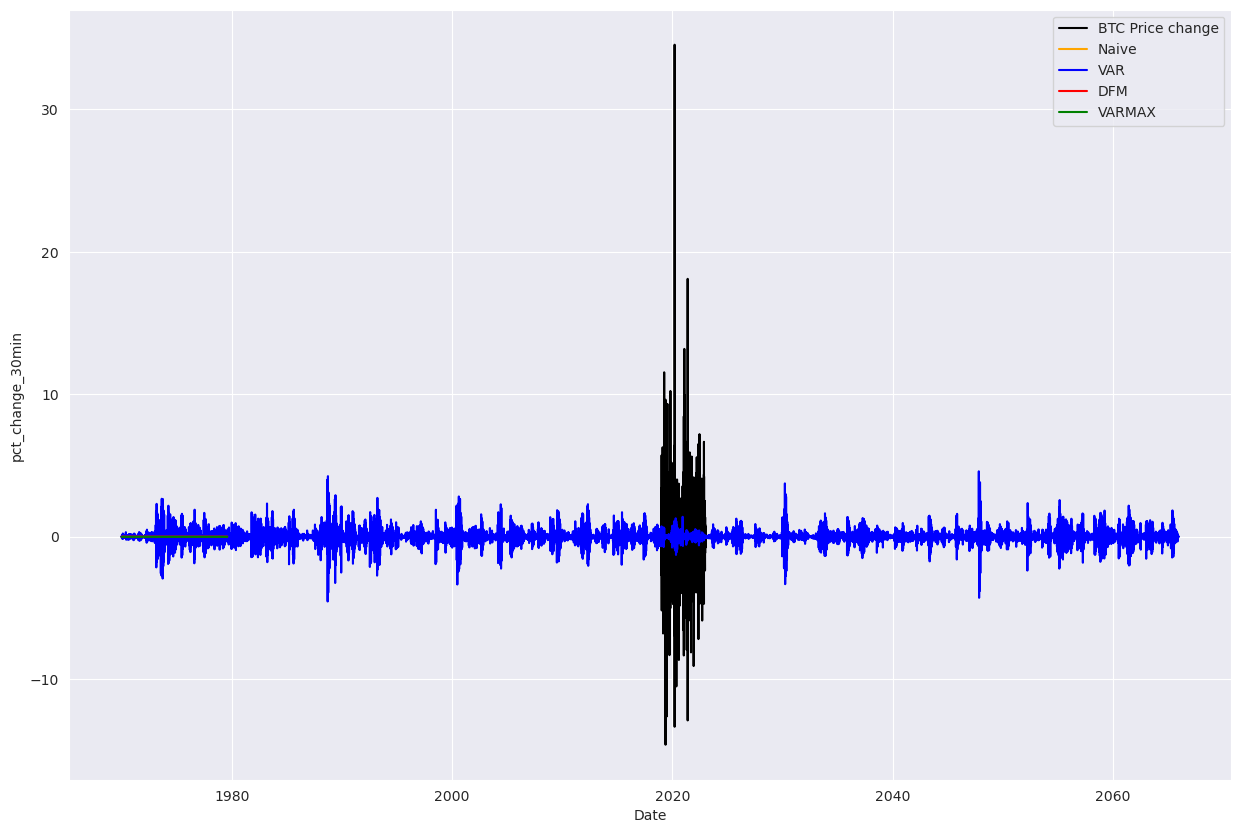

In [31]:
# plot btc 30min price and all the models
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(data=train_data['pct_change_30min'], ax=ax, label='BTC Price change', color='black')
sns.lineplot(data=naive_df['pct_change_30min'], ax=ax, label='Naive', color='orange')
sns.lineplot(data=var_df['pct_change_30min'], ax=ax, label='VAR', color='blue')
sns.lineplot(data=dfm_df['pct_change_30min'], ax=ax, label='DFM', color='red')
sns.lineplot(data=varmax_df['pct_change_30min'], ax=ax, label='VARMAX', color='green')


In [34]:
# if pct_change_30min is negative then set it to 0, if pct_change_30min is positive then set it to 1
naive_signal = naive_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
var_signal = var_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
dfm_signal = dfm_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
varmax_signal = varmax_df['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)
btc_signal = train_data['pct_change_30min'].apply(lambda x: 0 if x < 0 else 1)

In [35]:
btc.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [16]:
btc['Datetime'] = pd.to_datetime(btc['Timestamp'], unit='s')
btc.set_index('Datetime', inplace=True)

date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:45:00', freq='15min')
btc = btc.reindex(date_range)
btc = btc.interpolate()

# btc prices in 15min intervals
btc_prices = btc['Open']

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_strategy(price_df, prediction_df, strategy_function):
    """
    Backtests a trading strategy based on price and prediction data.

    Args:
        price_df (pd.DataFrame): DataFrame with 'timestamp' and 'price' columns.
        prediction_df (pd.DataFrame): DataFrame with 'timestamp' and 'prediction' columns.
        strategy_function (callable): Function accepting price, actual change and pred. change and implements strategy
            returning score.

    Returns:
        pd.DataFrame: DataFrame with backtest results
    """

    merged_df = pd.merge(price_df, prediction_df, on='timestamp', how='inner') # merge datas on timestamps

    merged_df['actual_change'] = np.nan

    for i in range(len(merged_df) - 2):
        merged_df.loc[i, 'actual_change'] = merged_df.loc[i + 2, 'price'] - merged_df.loc[i, 'price'] # calculate actual change

    merged_df.dropna(inplace=True) # remove last 2 rows (cant calculate actual change for them)
    backtest_results = []
    score = 0;
    for index, row in merged_df.iterrows():
        score = score + strategy_function(row['price'],row['actual_change'], row['prediction']) # implement  strategy function and accumulating score
        backtest_results.append(score)

    merged_df['strategy_score']  = backtest_results #add score to df

    return merged_df


def simple_strategy(price,actual_change, predicted_change, threshold = 0):
    """
    A simple example strategy that trades based on the predicted change. returns a score (not profit)
            Args:
                price (float): current price
                actual_change (float): actual 30 min change
                predicted_change (float): predicted 30 min change
                threshold (float): threshold value when prediction must be higher to act
            Returns:
               score (float): changes how well the bot is doing
    """
    if predicted_change > threshold:
       return   actual_change # predicted up and it did go up = good
    elif predicted_change < -threshold:
        return - actual_change # predicted down and it did go down = good
    else:
       return 0 # not trading



# Sample data (replace with your actual data)
data_prices = {
    'timestamp': pd.to_datetime(pd.date_range('2024-01-01', periods=40, freq='15Min')),
    'price': np.random.uniform(40000, 42000, size=40),
}

data_predictions = {
    'timestamp': pd.to_datetime(pd.date_range('2024-01-01', periods=40, freq='15Min')),
    'prediction': np.random.uniform(-100, 100, size=40), # Random prediction of 30min future change
}


price_df = pd.DataFrame(data_prices)
prediction_df = pd.DataFrame(data_predictions)




             timestamp         price  prediction  actual_change  \
0  2024-01-01 00:00:00  40988.596455   77.325323     635.000225   
1  2024-01-01 00:15:00  40320.892581   53.585895    -160.630343   
2  2024-01-01 00:30:00  41623.596679  -58.596500    -824.104398   
3  2024-01-01 00:45:00  40160.262238   44.873833     930.794747   
4  2024-01-01 01:00:00  40799.492281   25.077952    -526.222428   
5  2024-01-01 01:15:00  41091.056985  -92.609573     635.947486   
6  2024-01-01 01:30:00  40273.269853   85.304216     270.374828   
7  2024-01-01 01:45:00  41727.004471   85.807603    -638.719475   
8  2024-01-01 02:00:00  40543.644681   80.211266    1447.936417   
9  2024-01-01 02:15:00  41088.284996   17.893791     106.518379   
10 2024-01-01 02:30:00  41991.581098   79.681013    -292.756226   
11 2024-01-01 02:45:00  41194.803375  -82.618563    -686.639450   
12 2024-01-01 03:00:00  41698.824872  -45.583966   -1252.982406   
13 2024-01-01 03:15:00  40508.163925   75.370654     469.55360

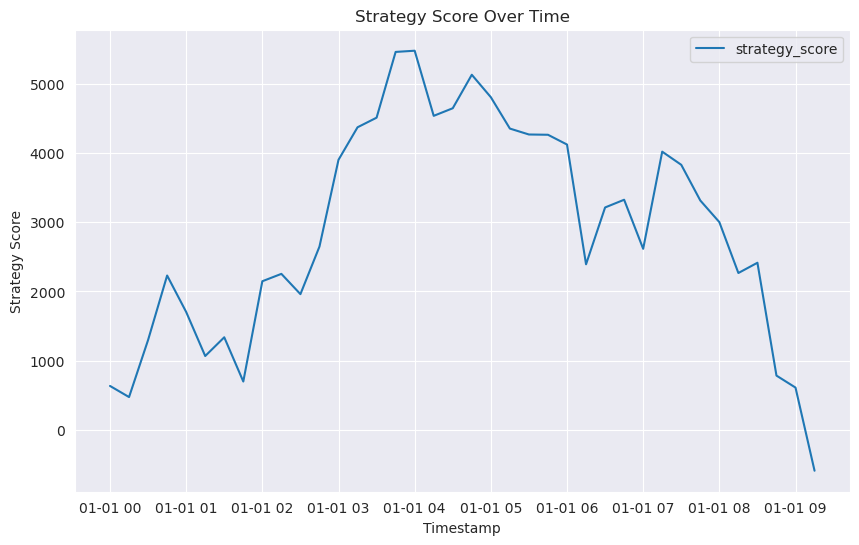

In [18]:
# Run the backtest with the strategy that predicts up  or down
results_df = backtest_strategy(price_df, prediction_df,simple_strategy)

# Print results
print(results_df)

# Plotting score
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(results_df['timestamp'], results_df['strategy_score'], label='strategy_score')
plt.xlabel('Timestamp')
plt.ylabel('Strategy Score')
plt.title('Strategy Score Over Time')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
# money = 1000000
# btc_holdings = 1
# portfolio_values = []
#
# signals = [naive_signal, var_signal, dfm_signal, varmax_signal, btc_signal]
# signal_names = ['Naive', 'VAR', 'DFM', 'VARMAX', 'BTC']
# min_length = min(len(btc_prices), len(signals[0]))
#
# for j in range(len(signals)):
#     signal = signals[j]
#     for i in range(min_length):
#         current_price = btc_prices.iloc[i]
#         if signal.iloc[i] == 1:
#             # Buy 1 BTC
#             money -= current_price
#             btc_holdings += 1
#         elif signal.iloc[i] == 0:
#             # Sell 1 BTC
#             money += current_price
#             btc_holdings -= 1
#         portfolio_value = money + btc_holdings * current_price
#         portfolio_values.append(portfolio_value)
#     print(f"{signal_names[j]}: {portfolio_values[-1]}")